# Exploring data normalization and analysis in large TMT experimental designs
## Part 2 - Statistical testing

### Phil Wilmarth, OHSU PSR Core, January 2018
In Part 1, several normalization methods were used on a developing mouse lens TMT study that spanned three 6-plex TMT labeling experiments. It was clear that an IRS-like procedure is critical to combining data from multiple TMT experiments because the different TMT experiments act like different batches. We also saw that increases in expression of several highly abundant lens proteins during the time course created a compositional bias in the samples that could be corrected by procedures like TMM.

In this second part, we will explore how using or not using IRS affects downstream statistical testing. This is actually rather complicated. The study is a 6 point time course with 3 replicates at each time. The obvious type of statistical testing would be a trend analysis using an ANOVA of some sort. Interpretation of ANOVA results is considerably harder than a pairwise comparison. In the time course, time points are all 3 days apart. We have two embryonic time points and several post-natal time points up to 9 days. We can create an "early" condition by averaging the E15 and E18 samples. We can take the P6 and P9 data, average that, and make a "late" post-natal condition. This would give use 6 samples in each condition and we could do a more straightforward pairwise comparison.

There is still the question of what statistical test to perform and what software to use. A simple two-sample t-test could be used, but that does not scale up to more complicated study designs where ANOVA and more general linear models would let us handle real-world biological studies. There are several statistical packages developed for genomic studies, such as limma, edgeR, and DESeq2, that are capable of these real world study designs. These packages are particularly well suited for studies with smaller numbers of replicates (2-5 replicates) because they use borrowing of information from other genes to better estimate variances.

> Ritchie, M.E., Phipson, B., Wu, D., Hu, Y., Law, C.W., Shi, W. and Smyth, G.K., 2015. limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucleic acids research, 43(7), pp.e47-e47.

> Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

> Love, M.I., Huber, W. and Anders, S., 2014. Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2. Genome biology, 15(12), p.550.

> Anders, S., McCarthy, D.J., Chen, Y., Okoniewski, M., Smyth, G.K., Huber, W. and Robinson, M.D., 2013. Count-based differential expression analysis of RNA sequencing data using R and Bioconductor. Nature protocols, 8(9), p.1765.

Some of these tools are formally designed for RNA-Seq count data and whether or not they are appropriate for use with TMT data is a fair question. DESeq2 and edgeR use negative binomial models that have two terms for variance. One is the Poisson term (the standard deviation is the square root of the number) and the other is an over-dispersion term. In RNA-Seq, counts are typically large and the variance due to the Poisson distribution is small compared to other sources of variation like biological variation. Modeling RNA-Seq data with just Poisson variance does not work. Additional variation provided by the over-dispersion term is required to correctly model the measurements. Peak height intensities are also very large numbers in raw files from Thermo instruments using the SPS MS3 method (particularly when we combine them into protein totals). If the scale of our data is appropriate, we can safely use tools like edgeR and DESeq2 with the flexible negative binomial model. These tools can be easier to use than limma, particularly for pair-wise comparisons.

We will illustrate using edgeR to perform a classic exact test between the early and late combined groups. The edgeR user's guide is well written, and edgeR has several data structures and methods that have to be used to complete this analysis. EdgeR also supports more complicated experiments with general linear model extensions. We will also leverage R's powerful visualization capabilities and the ggplot2 package to visualize our results.

<br>


### Let's start fresh and reload the data

In [1]:
# Analysis of IOVS mouse lens data (Supplemental Table S01):
# Khan, Shahid Y., et al. "Proteome Profiling of Developing Murine Lens Through Mass Spectrometry." 
# Investigative Ophthalmology & Visual Science 59.1 (2018): 100-107.

# load libraries
library(tidyverse) # modern R packages for big data analysis
library(limma) # edgeR will load this if we do not
library(edgeR)

# read the Supplemental 01 file (saved as a CSV export from XLSX file)
data_start <- read_csv("iovs-58-13-55_s01.csv")

# filter out proteins not seen in all three runs
data_no_na <- na.omit(data_start)

# fix the column headers
col_headers <- colnames(data_no_na)
col_headers <- str_replace(col_headers, " {2,3}", " ")
col_headers <- str_replace(col_headers, "Reporter ion intensities ", "")
colnames(data_no_na) <- col_headers

# save the annotation columns (gene symbol and protein accession) for later and remove from data frame
annotate_df <- data_no_na[1:2]
data_raw <- data_no_na[3:20]
row.names(data_raw) <- annotate_df$`Protein Accession No.`

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Parsed with column specification:
cols(
  .default = col_double(),
  `Gene Symbol (NCBI)` = col_character(),
  `Protein Accession No.` = col_character()
)
See spec(...) for full column specifications.
Warning message:
“Setting row names on a tibble is deprecated.”

### We need to do SL and IRS normalizations

In [2]:
# separate the TMT data by experiment
exp1_raw <- data_raw[c(1:6)]
exp2_raw <- data_raw[c(7:12)]
exp3_raw <- data_raw[c(13:18)]

# figure out the global scaling value
target <- mean(c(colSums(exp1_raw), colSums(exp2_raw), colSums(exp3_raw)))

# do the sample loading normalization before the IRS normalization
# there is a different correction factor for each column
# seems like a loop could be used here somehow...
norm_facs <- target / colSums(exp1_raw)
exp1_sl <- sweep(exp1_raw, 2, norm_facs, FUN = "*")
norm_facs <- target / colSums(exp2_raw)
exp2_sl <- sweep(exp2_raw, 2, norm_facs, FUN = "*")
norm_facs <- target / colSums(exp3_raw)
exp3_sl <- sweep(exp3_raw, 2, norm_facs, FUN = "*")

# make a pre-IRS data frame after sample loading norms
data_sl <- cbind(exp1_sl, exp2_sl, exp3_sl)

# make working frame with row sums from each frame
irs <- tibble(rowSums(exp1_sl), rowSums(exp2_sl), rowSums(exp3_sl))
colnames(irs) <- c("sum1", "sum2", "sum3")

# get the geometric average intensity for each protein
irs$average <- apply(irs, 1, function(x) exp(mean(log(x))))

# compute the scaling factor vectors
irs$fac1 <- irs$average / irs$sum1
irs$fac2 <- irs$average / irs$sum2
irs$fac3 <- irs$average / irs$sum3

# make new data frame with normalized data
data_irs <- exp1_sl * irs$fac1
data_irs <- cbind(data_irs, exp2_sl * irs$fac2)
data_irs <- cbind(data_irs, exp3_sl * irs$fac3)

## Exact pair-wise testing in edgeR
### What about TMM normalization?
We saw in Part 1 that TMM normalization effectively removed compositional bias from the data. What we want to see in this exercise is what effect the IRS method has on statistical testing. If we do not employ the TMM step, we will have a more predictable outcome. We know that crystallin expression will be much higher in the late samples compared to the early samples. This should result in a large number of statistically significant down-regulated proteins. This expected pattern will make it easier to see if we are getting the "right" results from the edgeR testing. It is always fun to think of ways to test methodology when there is no known outcome to use as a gold standard.  
### Setting up the experiment design and loading the data
We start with a matrix or data frame where the rows are the different protein expression levels and the columns are the biological samples. We need to get the data into an edgeR DGEList object. This data container holds the count data and the sample mapping information. We have to tell edgeR which samples belong to which groups. When we perform the statistical testing, we will have to specify which two groups are being compared. We will do an analysis of the SL data without IRS first. EdgeR will work better if we load all 18 samples in the DGEList object and estimate dispersions on the full dataset. We will limit the pair-wise comparison to the early versus late samples.


 Factor w/ 3 levels "early","middle",..: 1 1 2 2 3 3 1 1 2 2 ...


,group,lib.size,norm.factors
E15_Set1,early,9826475337,1
E18_Set1,early,9826475337,1
P0_Set1,middle,9826475337,1
P3_Set1,middle,9826475337,1
P6_Set1,late,9826475337,1
P9_Set1,late,9826475337,1
E15_Set2,early,9826475337,1
E18_Set2,early,9826475337,1
P0_Set2,middle,9826475337,1
P3_Set2,middle,9826475337,1


Design matrix not provided. Switch to the classic mode.


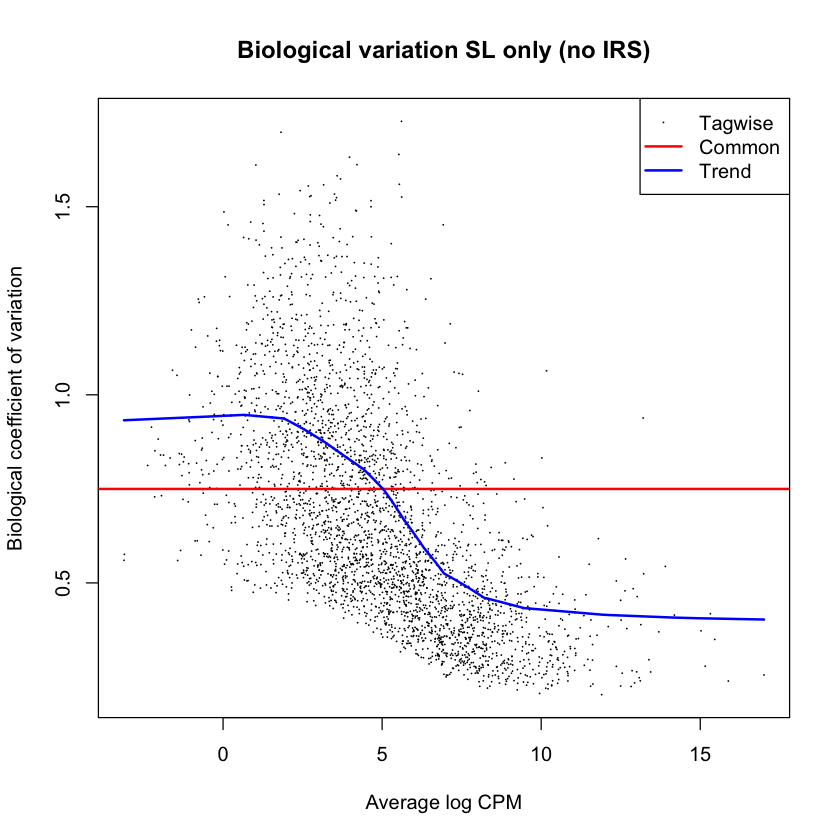

In [3]:
# set up the sample mapping
group <- rep(c("early", "early", "middle", "middle", "late", "late"), 3)

# make group into factors and set the order
group <- factor(group, levels = c("early", "middle", "late"))
str(group)

# create a DGEList object with our data
y_sl <- DGEList(counts = data_sl, group = group)

# y_sl is a list: y_sl$counts is the data, and y_sl$samples has interesting content
y_sl$samples

# we will skip running TMM (using the calcNormFactors function)
# we need to estimate the dispersion terms (global and local)
y_sl <- estimateDisp(y_sl)
plotBCV(y_sl, main = "Biological variation SL only (no IRS)")

### Do the Exact test between early and late and see how many candidates (FDR < 0.05)
We have loaded the data, skipped any additional TMM normalizations, and estimated dispersion factors for the statistical modeling. Now we will perform a modified Fisher's exact test between the early and late groups.

In [4]:
# the exact test object has columns like fold-change, CPM, and p-values
et_sl <- exactTest(y_sl, pair = c("early", "late"))
summary(decideTestsDGE(et_sl)) # this counts up, down, and unchanged genes (here it is proteins)

       early+late
Down         1086
NotSig       2020
Up             49

### Expression pattern looks reasonable, right?
Remember that we expect a few proteins to be up-regulated and a large number to be down-regulated. That is what we have, right? Maybe. We know that IRS reduces variance. However, large enough difference will be statistically significant despite high variance. It is a question of how big the difference in the means are compared to the variance. Let's categorize our test results by Benjamini-Hochberg corrected FDR values and visualize the results.

In [5]:
# the topTags function adds the BH FDR values to an exactTest data frame. Make sure we do not change the row order!
tt_sl <- topTags(et_sl, n = Inf, sort.by = "none")
tt_sl <- tt_sl$table # tt_sl is a list. We just need the data frame table

# add the default value as a new column
tt_sl$candidate <- "no"
tt_sl[which(tt_sl$FDR <= 0.10 & tt_sl$FDR > 0.05), dim(tt_sl)[2]] <- "low"
tt_sl[which(tt_sl$FDR <= 0.05 & tt_sl$FDR > 0.01), dim(tt_sl)[2]] <- "med"
tt_sl[which(tt_sl$FDR <= 0.01), dim(tt_sl)[2]] <- "high"
tt_sl$candidate <- factor(tt_sl$candidate, levels = c("high", "med", "low", "no"))

# what does tt_sl look like?
head(tt_sl)

logFC,logCPM,PValue,FDR,candidate
0.9461843,17.00380,1.065516e-05,1.263798e-04,high
0.7306164,15.45547,1.282726e-02,3.898844e-02,med
0.5724531,15.88236,4.224372e-03,1.676465e-02,med
0.9555125,15.15550,4.619687e-05,4.286798e-04,high
4.6614479,13.20560,4.651407e-07,1.040794e-05,high
1.5460286,13.90162,9.137656e-04,5.111579e-03,high


### Is the statistical test behaving correctly?
This situation is somewhat extreme from many other comparisons. In many experiments, there will be a large number of non-differentially-expressed proteins. Those should produce a uniformly distributed (flat) background of p-values (at all values from 0.0 to 1.0). Any true differential candidates will be a second distribution peaked at very small p-values.

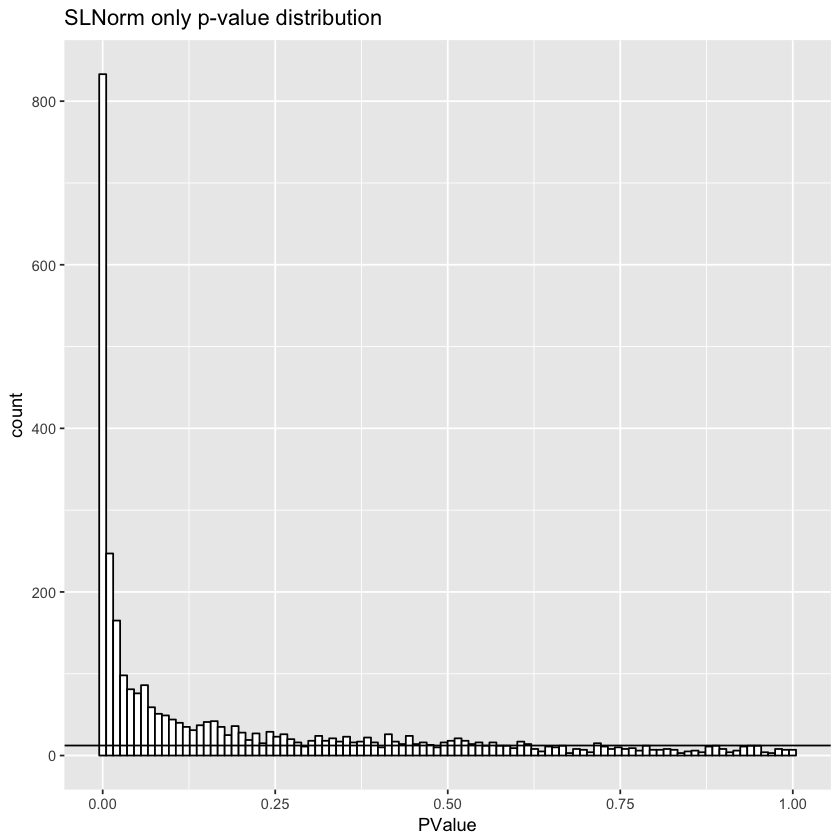

In [6]:
# what does the test p-value distribution look like?
ggplot(tt_sl, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(tt_sl$PValue, breaks = 100, plot = FALSE)$counts[26:100])) +
  ggtitle("SLNorm only p-value distribution")

In [7]:
# for plotting results, we will use the average intensities for the 6 early and the 6 late samples
early <- c(1, 2, 7, 8, 13, 14)
late <- c(5, 6, 11, 12, 17, 18)
de_sl <- data.frame(rowMeans(data_sl[early]), rowMeans(data_sl[late]), tt_sl$candidate)
colnames(de_sl) <- c("early", "late", "candidate")
head(de_sl)
volcano_sl <- data.frame(log2(rowMeans(data_sl[early])/rowMeans(data_sl[late])), log10(tt_sl$FDR)*(-1), tt_sl$candidate)
colnames(volcano_sl) <- c("FoldChange", "FDR", "candidate")
head(volcano_sl)

early,late,candidate
832146428,1603354681,high
327426585,543314614,med
466113648,693134282,med
230022598,446075572,high
8962837,226819890,high
76344338,222934768,high


FoldChange,FDR,candidate
-0.9461843,3.898322,high
-0.7306164,1.409064,med
-0.5724531,1.775606,med
-0.9555125,3.367867,high
-4.6614479,4.982635,high
-1.5460286,2.291445,high


### Make a scatter plot and color code by candidate status
The solid diagonal line is the unity line and the dotted lies are plus/minus 2-fold. Proteins with FDR values less than 0.01 are "high" significance candidates (orange), proteins with FDR between 0.05 and 0.01 are "medium" (sea green), proteins with FDR between 0.10 and 0.05 are "low" (teal), and proteins with FDR greater than 0.10 are non-candidates ("no", in purple).


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



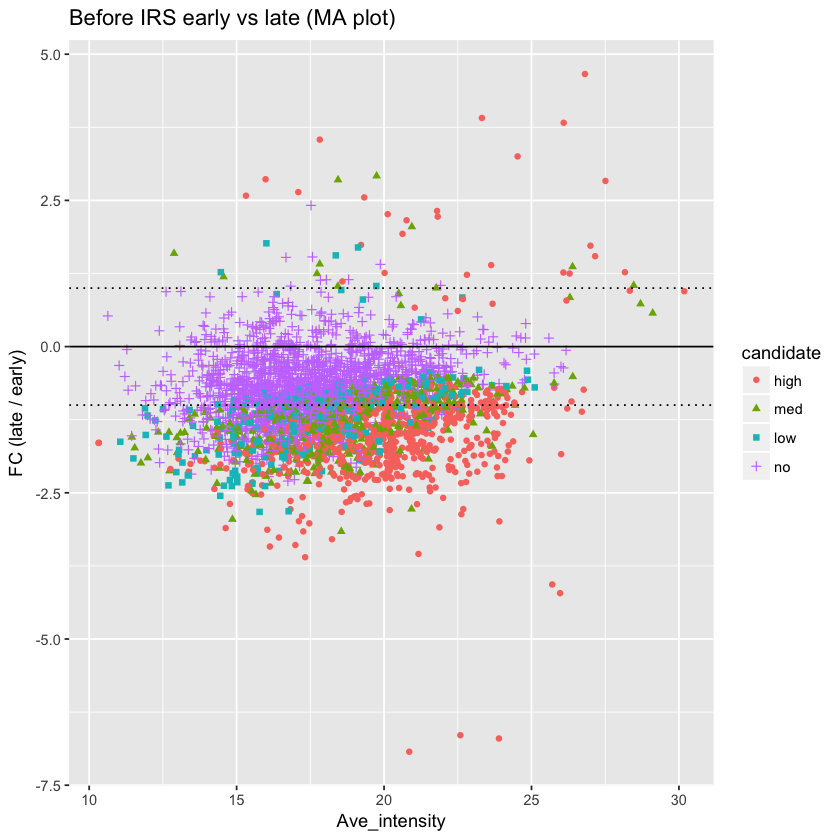

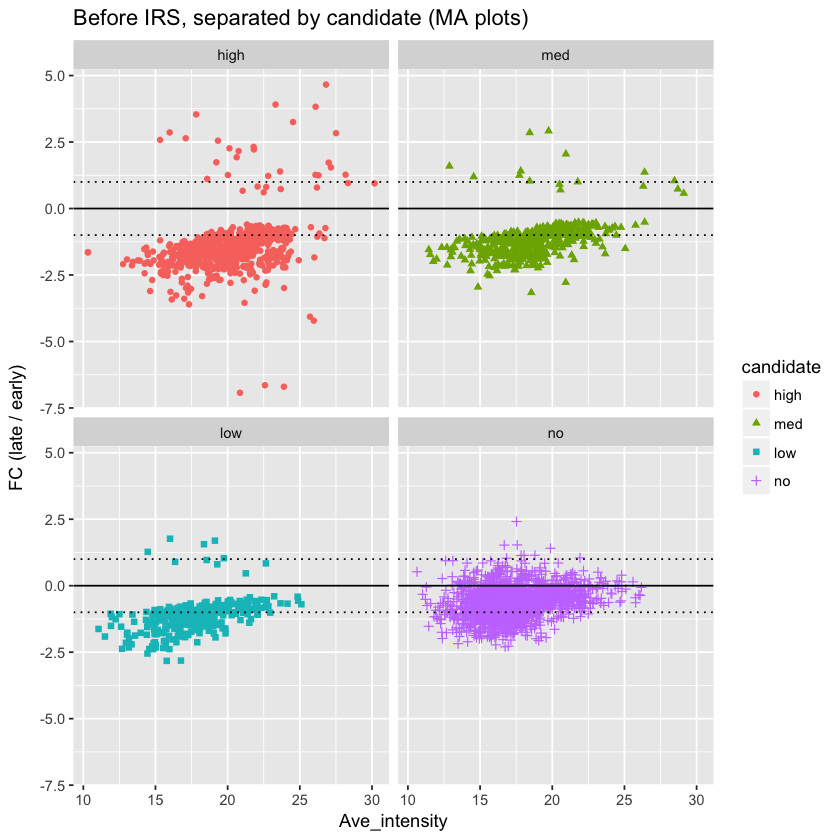

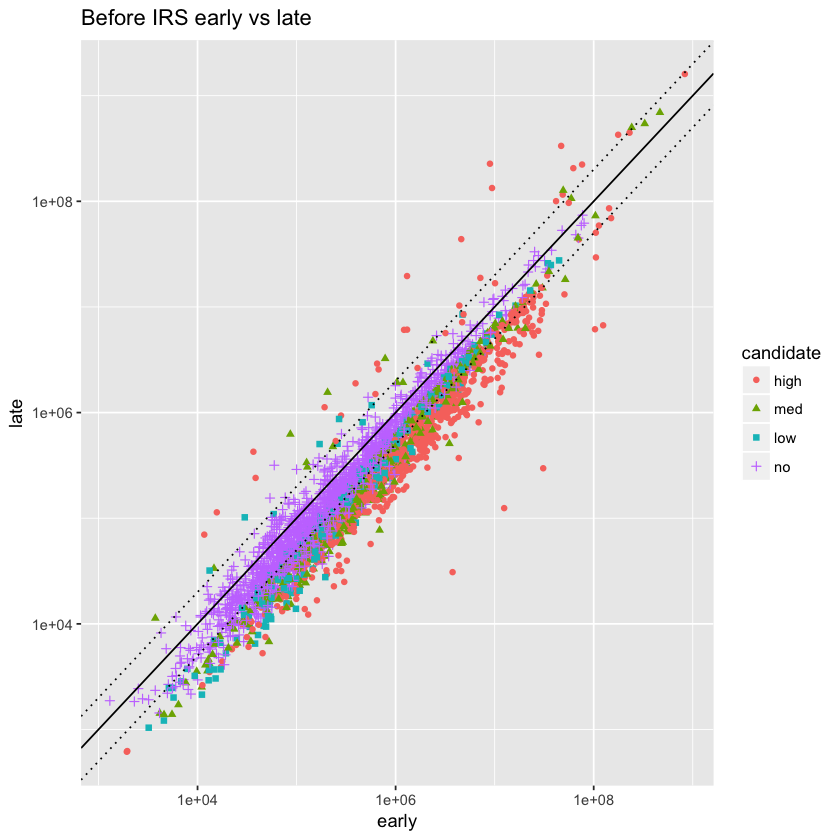

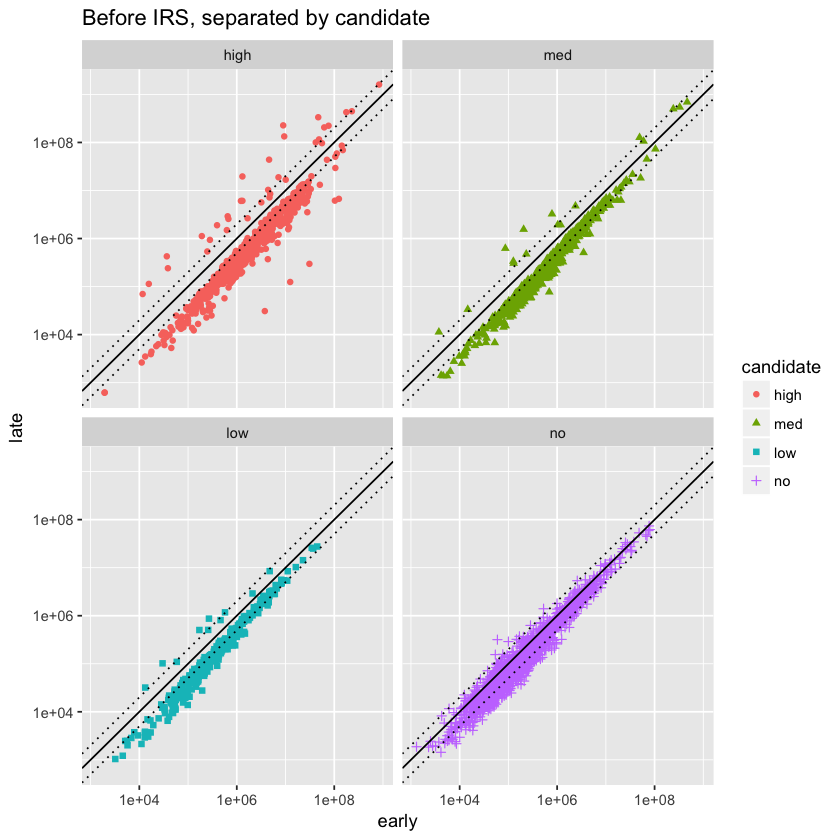

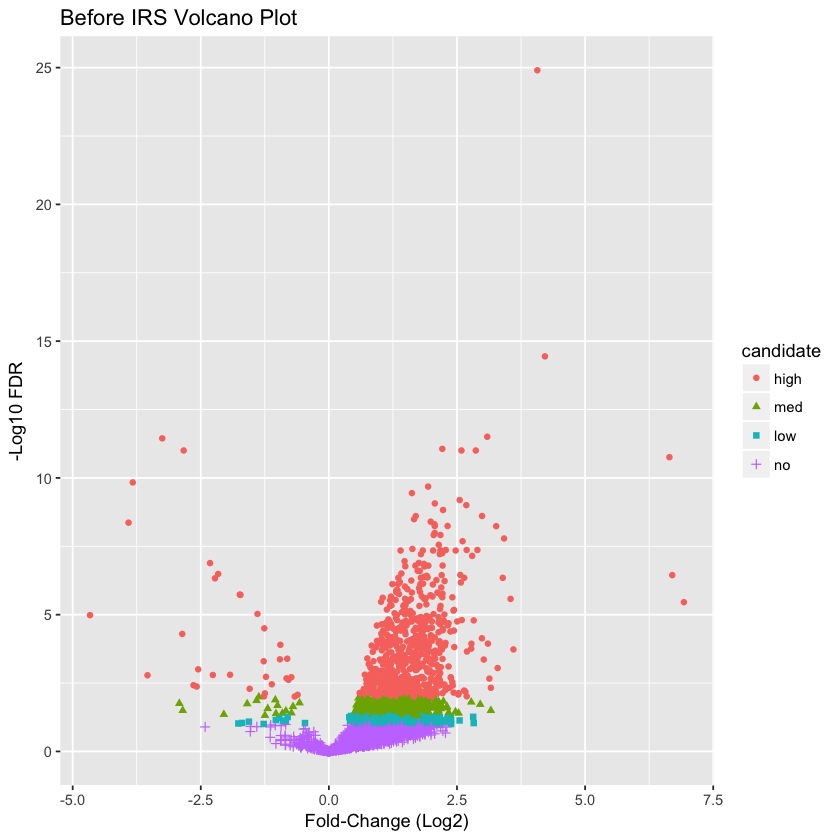

In [8]:
# start with MA plot
library(scales)
temp <- data.frame(log2((de_sl$early + de_sl$late)/2), log2(de_sl$late/de_sl$early), de_sl$candidate)
colnames(temp) <- c("Ave", "FC", "candidate")
ggplot(temp, aes(x = Ave, y = FC)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_continuous("FC (late / early)") +
  scale_x_continuous("Ave_intensity") +
  ggtitle("Before IRS early vs late (MA plot)") + 
  geom_hline(yintercept = 0.0, color = "black") + # one-to-one line
  geom_hline(yintercept = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_hline(yintercept = -1.0, color = "black", linetype = "dotted") # 2-fold down

# make separate MA plots
ggplot(temp, aes(x = Ave, y = FC)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_continuous("FC (late / early)") +
  scale_x_continuous("Ave_intensity") +
  geom_hline(yintercept = 0.0, color = "black") + # one-to-one line
  geom_hline(yintercept = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_hline(yintercept = -1.0, color = "black", linetype = "dotted") + # 2-fold down
  facet_wrap(~ candidate) +
  ggtitle("Before IRS, separated by candidate (MA plots)")

# make the combined candidate corelation plot
ggplot(de_sl, aes(x = early, y = late)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_log10() +
  scale_x_log10() +
  ggtitle("Before IRS early vs late") + 
  geom_abline(intercept = 0.0, slope = 1.0, color = "black") + # one-to-one line
  geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted") # 2-fold down

# make separate corelation plots
ggplot(de_sl, aes(x = early, y = late)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_log10() +
  scale_x_log10() +
  geom_abline(intercept = 0.0, slope = 1.0, color = "black") + # one-to-one line
  geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold down
  facet_wrap(~ candidate) +
  ggtitle("Before IRS, separated by candidate")

# make a volcano plot
ggplot(volcano_sl, aes(x = FoldChange, y = FDR)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  xlab("Fold-Change (Log2)") +
  ylab("-Log10 FDR") +
  ggtitle("Before IRS Volcano Plot")

## Now let's see what effect IRS has
### Same steps, different data

,group,lib.size,norm.factors
E15_Set1,early,9270664774,1
E18_Set1,early,9363761294,1
P0_Set1,middle,9451622436,1
P3_Set1,middle,9531837394,1
P6_Set1,late,9537837657,1
P9_Set1,late,9566996326,1
E15_Set2,early,9253060468,1
E18_Set2,early,9135830721,1
P0_Set2,middle,9597066116,1
P3_Set2,middle,9528757306,1


Design matrix not provided. Switch to the classic mode.


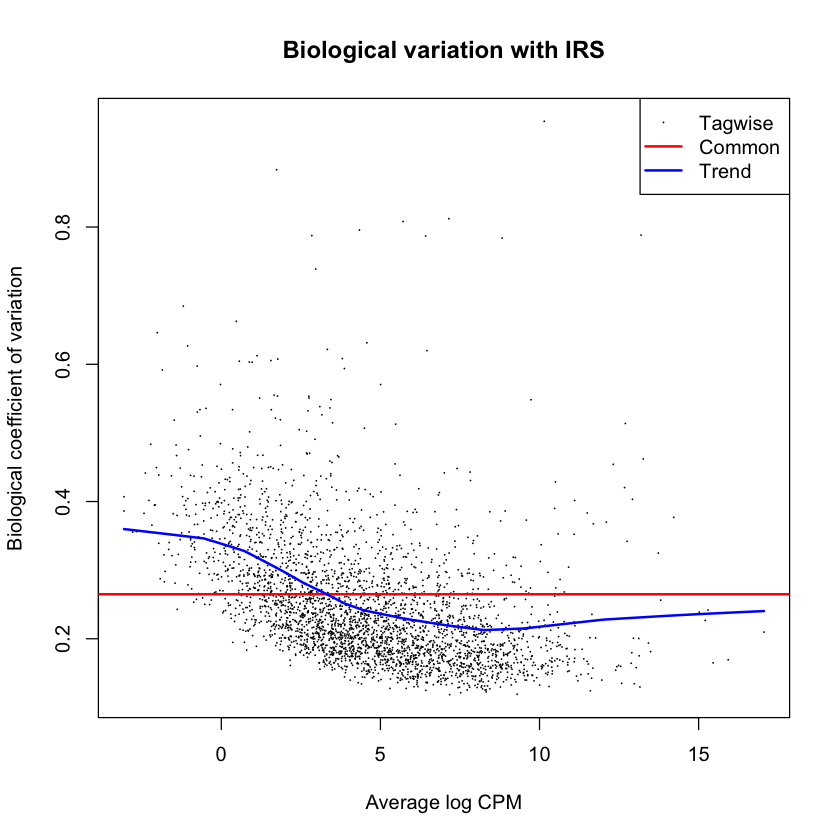

In [9]:
# create a DGEList object with the IRS data
y_irs <- DGEList(counts = data_irs, group = group)

# y_irs is a list: y_irs$counts is the data, and y_irs$samples has interesting content
y_irs$samples

# we will skip running TMM (using the calcNormFactors function)
# we need to estimate the dispersion terms (global and local)
y_irs <- estimateDisp(y_irs)
plotBCV(y_irs, main = "Biological variation with IRS")

### Library sizes vary a little after IRS and biological variation is greatly reduced

In [10]:
# the exact test object has columns like fold-change, CPM, and p-values
et_irs <- exactTest(y_irs, pair = c("early", "late"))
summary(decideTestsDGE(et_irs)) # this counts up, down, and unchanged genes

       early+late
Down         2629
NotSig        405
Up            121

## Wow! That is really different
### We went from 2000 non-differentially expressed proteins to only 400
We really see that the small number of lens-specific proteins is **pushing all of the other proteins down in expression**. This is the view of reality that we have learned from decades of lens study. In 2D gel studies of young mouse lenses, only crystallins are visible suggesting that they make up over 90% of the soluble lens proteins. We know that the number of lens-specific proteins is quite small. There are some intermediate filament proteins also present in the cytosol along with the crystallins. The plasma membrane of mature lens fiber cells is also very unique, with very high levels of aquaporin 0 and some other gap junctions.

> Ueda, Y., Duncan, M.K. and David, L.L., 2002. Lens proteomics: the accumulation of crystallin modifications in the mouse lens with age. Investigative ophthalmology & visual science, 43(1), pp.205-215.

> Bassnett, S., Wilmarth, P.A. and David, L.L., 2009. The membrane proteome of the mouse lens fiber cell. Molecular vision, 15, p.2448.

logFC,logCPM,PValue,FDR,candidate
0.9131552,17.05413,2.221303e-07,4.377397e-07,high
0.7450530,15.45429,7.060640e-08,1.464584e-07,high
0.5557584,15.92931,8.676523e-05,1.267922e-04,high
0.9450249,15.20561,7.215901e-07,1.315203e-06,high
5.0175909,13.18974,1.781463e-10,5.337621e-10,high
1.6390592,13.80833,7.691303e-14,4.017560e-13,high


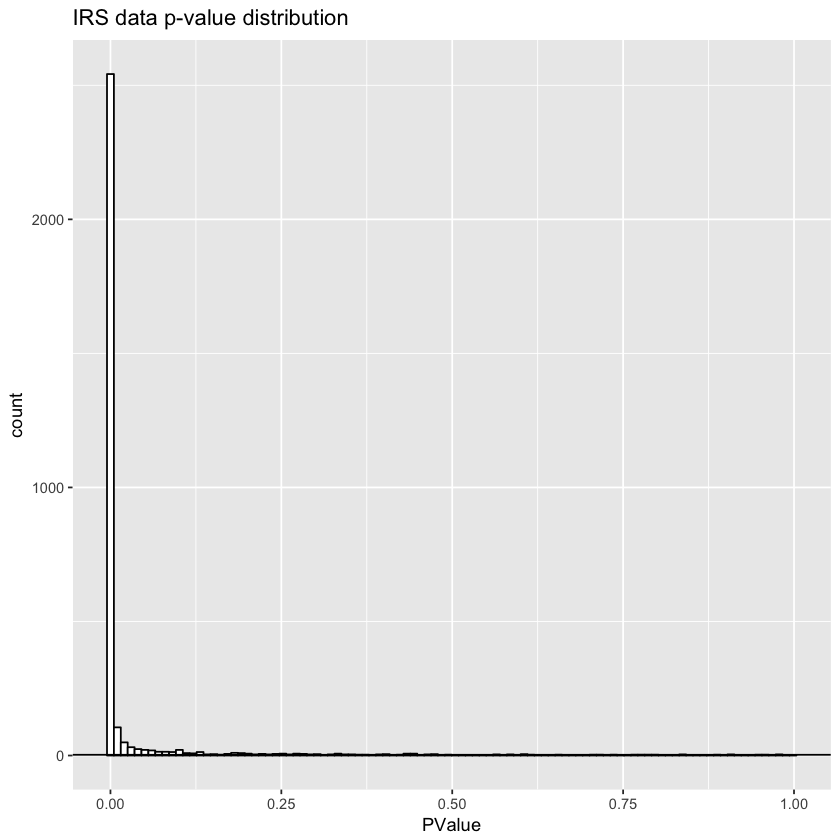

In [11]:
# the topTags function adds the BH FDR values to an exactTest data frame. Make sure we do not change the row order!
tt_irs <- topTags(et_irs, n = Inf, sort.by = "none")
tt_irs <- tt_irs$table # tt_sl is a list. We just need the data frame table

# add the default value as a new column
tt_irs$candidate <- "no"
tt_irs[which(tt_irs$FDR <= 0.10 & tt_irs$FDR > 0.05), dim(tt_irs)[2]] <- "low"
tt_irs[which(tt_irs$FDR <= 0.05 & tt_irs$FDR > 0.01), dim(tt_irs)[2]] <- "med"
tt_irs[which(tt_irs$FDR <= 0.01), dim(tt_irs)[2]] <- "high"
tt_irs$candidate <- factor(tt_irs$candidate, levels = c("high", "med", "low", "no"))

# what does tt_sl look like?
head(tt_irs)

# what does the test p-value distribution look like?
ggplot(tt_irs, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(tt_irs$PValue, breaks = 100, plot = FALSE)$counts[26:100])) +
  ggtitle("IRS data p-value distribution")

early,late,candidate
834747205,1597669373,high
307958721,523891131,high
461201937,687806268,high
227963373,446059577,high
6623823,218333769,high
65235185,206428878,high


FoldChange,FDR,candidate
-0.9461843,3.898322,high
-0.7306164,1.409064,med
-0.5724531,1.775606,med
-0.9555125,3.367867,high
-4.6614479,4.982635,high
-1.5460286,2.291445,high


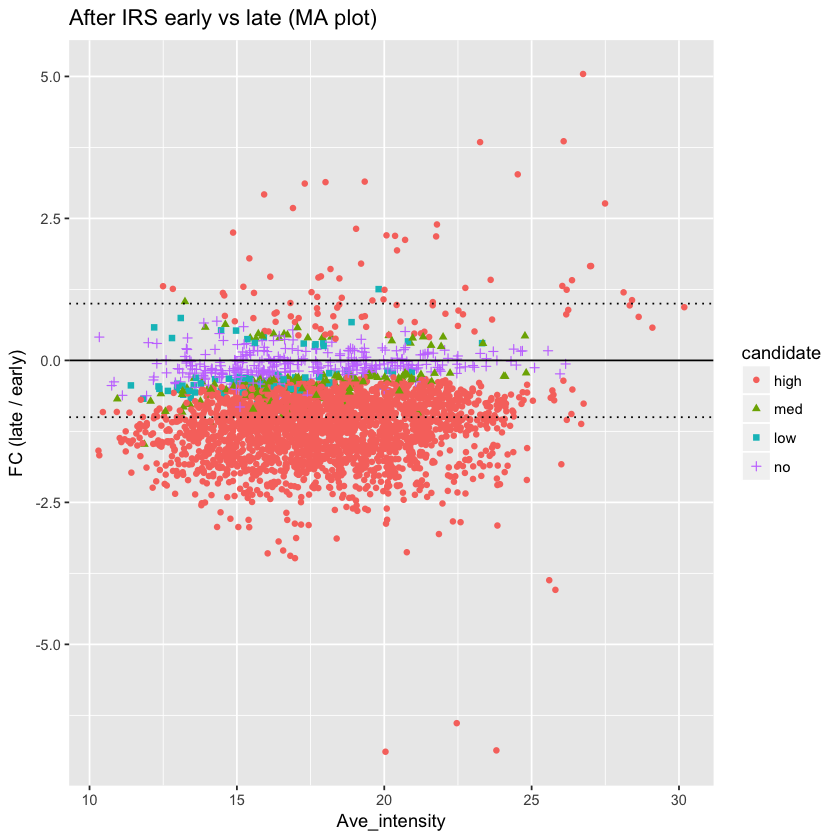

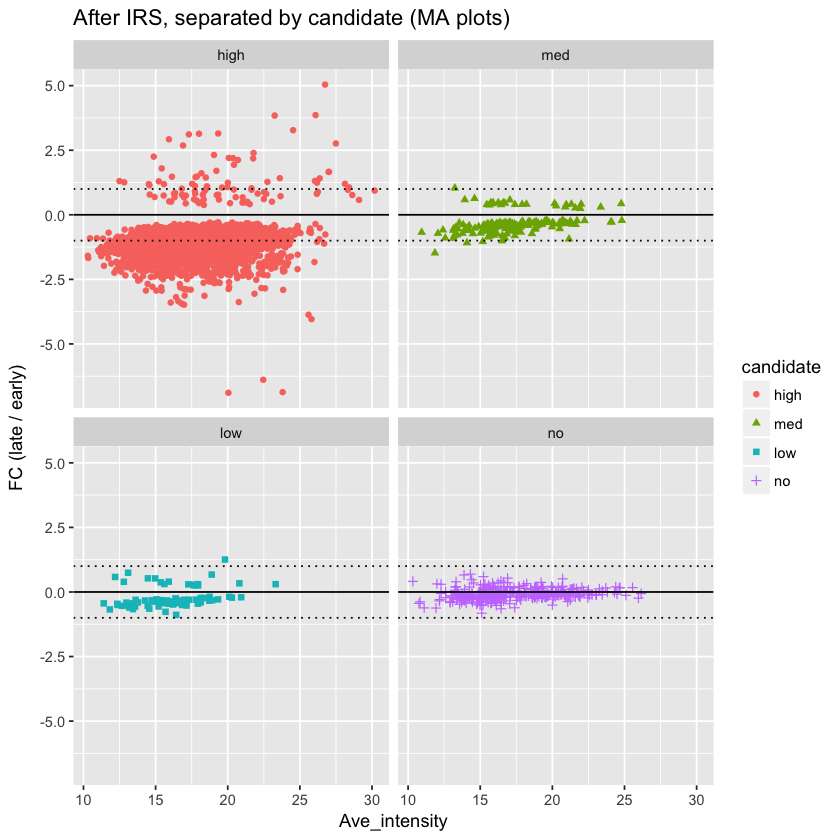

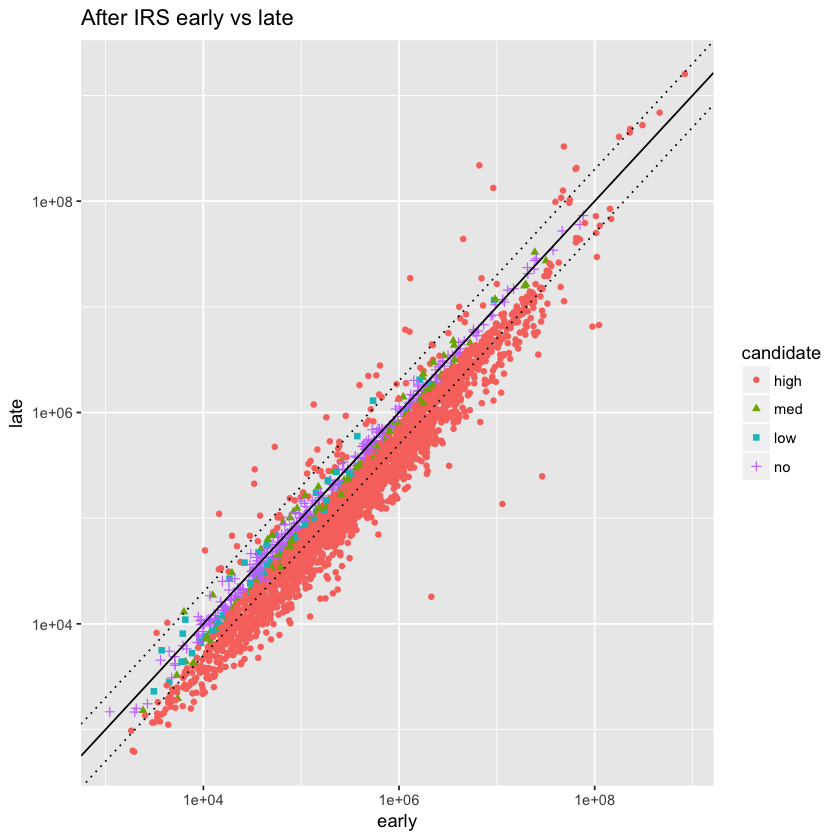

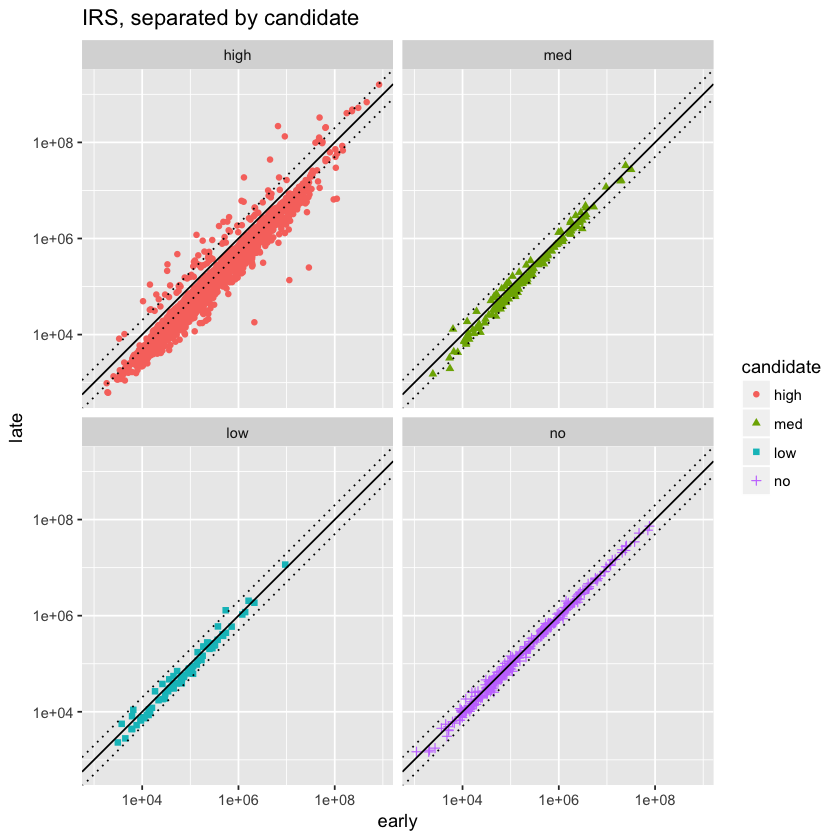

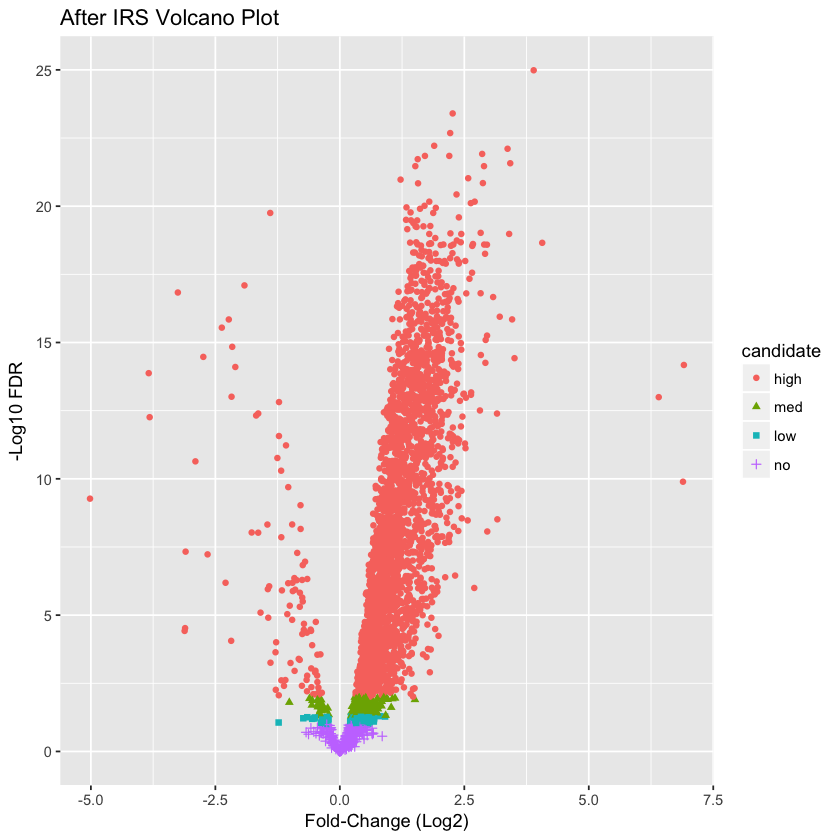

In [12]:
# for plotting results, we will use the average intensities for the 6 early and the 6 late samples
de_irs <- data.frame(rowMeans(data_irs[early]), rowMeans(data_irs[late]), tt_irs$candidate)
colnames(de_irs) <- c("early", "late", "candidate")
head(de_irs)
# volcano_irs <- data.frame(log2(rowMeans(data_irs[early])/rowMeans(data_irs[late])), log10(tt_irs$FDR)*(-1), tt_irs$candidate)
volcano_irs <- data.frame(-1*tt_irs$logFC, -1*log10(tt_irs$FDR), tt_irs$candidate)
colnames(volcano_irs) <- c("FoldChange", "FDR", "candidate")
head(volcano_sl)

# start with MA plot
temp <- data.frame(log2((de_irs$early + de_irs$late)/2), log2(de_irs$late/de_irs$early), de_irs$candidate)
colnames(temp) <- c("Ave", "FC", "candidate")
ggplot(temp, aes(x = Ave, y = FC)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_continuous("FC (late / early)") +
  scale_x_continuous("Ave_intensity") +
  ggtitle("After IRS early vs late (MA plot)") + 
  geom_hline(yintercept = 0.0, color = "black") + # one-to-one line
  geom_hline(yintercept = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_hline(yintercept = -1.0, color = "black", linetype = "dotted") # 2-fold down

# make separate MA plots
ggplot(temp, aes(x = Ave, y = FC)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_continuous("FC (late / early)") +
  scale_x_continuous("Ave_intensity") +
  geom_hline(yintercept = 0.0, color = "black") + # one-to-one line
  geom_hline(yintercept = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_hline(yintercept = -1.0, color = "black", linetype = "dotted") + # 2-fold down
  facet_wrap(~ candidate) +
  ggtitle("After IRS, separated by candidate (MA plots)")

# make the combined candidate corelation plot
ggplot(de_irs, aes(x = early, y = late)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_log10() +
  scale_x_log10() +
  ggtitle("After IRS early vs late") + 
  geom_abline(intercept = 0.0, slope = 1.0, color = "black") + # one-to-one line
  geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted") # 2-fold down

# make separate corelation plots
ggplot(de_irs, aes(x = early, y = late)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_log10() +
  scale_x_log10() +
  geom_abline(intercept = 0.0, slope = 1.0, color = "black") + # one-to-one line
  geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold down
  facet_wrap(~ candidate) +
  ggtitle("IRS, separated by candidate")

# make a volcano plot
ggplot(volcano_irs, aes(x = FoldChange, y = FDR)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  xlab("Fold-Change (Log2)") +
  ylab("-Log10 FDR") +
  ggtitle("After IRS Volcano Plot")

### Everything after IRS just looks better...
#### Let's look at the scatter plots of the 6-sample average early vs the 6-sample average late, before and after IRS 
We will not highlight candidates and we will add marginal histograms.

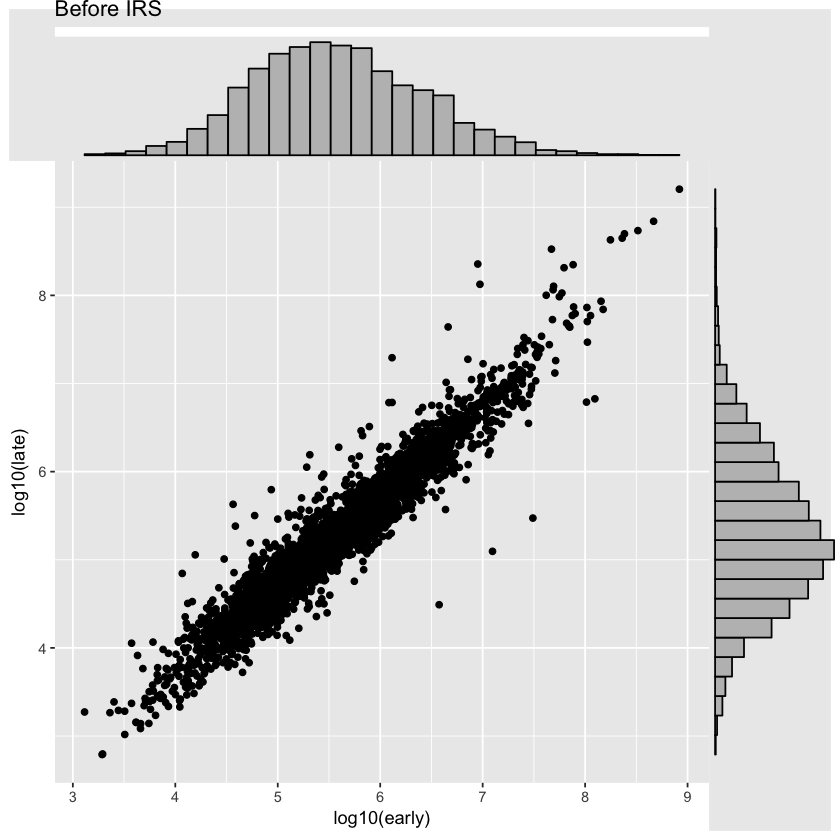

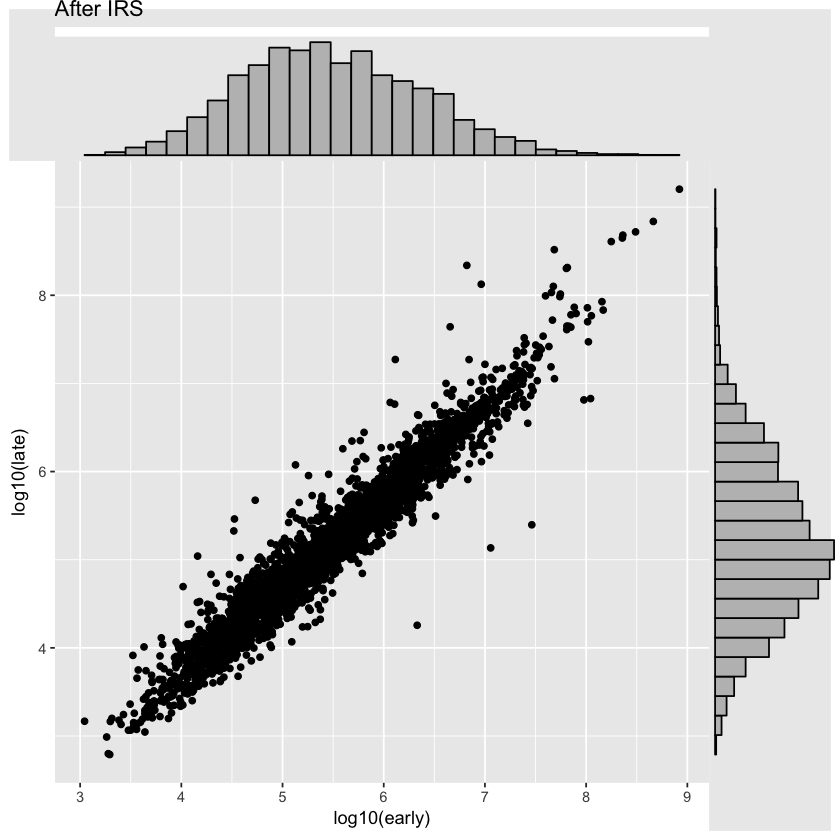

In [13]:
library(ggExtra)
# add marginal distrubution histograms to basic correlation plot (good starting point)
ggplot()
corr_plot <- ggplot(de_sl, aes(x = log10(early), y = log10(late))) +
  geom_point() + ggtitle("Before IRS")
ggMarginal(corr_plot, type = "histogram")

ggplot()
corr_plot <- ggplot(de_irs, aes(x = log10(early), y = log10(late))) +
  geom_point() + ggtitle("After IRS")
ggMarginal(corr_plot, type = "histogram")

## Above plots are almost the same!
### How can IRS make so little difference?
It is really quite simple. Each TMT experiment is **on average** relatively similar. Highly abundant proteins have large intensities, and low abundance proteins have low intensities. Each individual TMT experiment is a valid set of measurements. On average, relative intensities of different proteins within each TMT will have a similar pattern. The same protein between different TMT experiments will have similar within TMT relative intensities (a low abundance protein should always be a low abundance protein in each TMT experiment). The random MS2 sampling cannot make chromatography mountains out of molehills (or vice versa). The random sampling adds very significant variation but not quite enough to completely obscure the relative protein expression picture.

In these scatter plots, the early (x-axis) values are an average of 6 samples; so are the late values. The **average** before or after IRS are quite similar, as are the overall distributions of average protein intensities. Just as we saw in Part 1 with normalizations, it is critical to use the right metrics to evaluate analysis choices. Some very sensible data summaries and visualizations are simply incapable of probing the important differences.

## Let's examine the expression of some individual proteins - crystallins
### Create a function to make this easier to call for either SL or IRS data
We will plot crystallins at each time point as a bar plot with the bar height being the averge of the 3 replicates and error bars at plus/minus one standard deviation. We will do the SL (no TMM and no IRS) data first.

In [14]:
# create some functions
subset_proteins <- function(df, proteins, labels, value_col) {  
  df_subset <- subset(df, df$protein %in% proteins)
  df_subset <- df_subset[match(proteins, df_subset$protein), ]
  df_subset$proteins <- as.factor(labels)
  keycol <- "time"
  valuecol <- value_col
  gathercols <- colnames(df)[1:6]
  return(gather_(df_subset, keycol, valuecol, gathercols))
}

plot_proteins <- function(df_list, annotate_df) {
  ave_df <- df_list[[1]]
  sd_df <- df_list[[2]]
  
  # lists of lens proteins to extract and plot
  alphas <- c("P24622", "P23927")
  alpha_labels <- c("alphaA", "alphaB")
  betas <- c("P02525", "Q9JJV1", "Q9JJV0","Q9WVJ5",	"P62696", "Q9JJU9", "O35486")	
  beta_labels <- c("betaA1", "betaA2", "betaA4", "betaB1", "betaB2", "betaB3", "betaS")
  gammas <- c("P04345", "P04344", "Q61597", "P04342", "Q03740", "Q9CXV3", "Q8VHL5")
  gamma_labels <- c("gammaA", "gammaB", "gammaC", "gammaD", "gammaE", "gammaF", "gammaN")
  ave_df$protein <- annotate_df$`Protein Accession No.`
  sd_df$protein <- annotate_df$`Protein Accession No.`
  # plot alphas
  ave_df_wide <- subset_proteins(ave_df, alphas, alpha_labels, "intensity")
  sd_df_wide <- subset_proteins(sd_df, alphas, alpha_labels, "sd")
  ave_df_wide$sd <- sd_df_wide$sd
  alpha_plot <- ggplot(ave_df_wide, aes(time, intensity, fill=proteins)) + 
    geom_bar(stat="identity", position=position_dodge(), colour="black") +
    geom_errorbar(aes(ymin = intensity-sd, ymax = intensity+sd), position = position_dodge(0.9), width = 0.4) +
    xlab("Developmental Time") + ylab("Total Protein Intensity") +
    ggtitle("Alpha crystallin expression")
  print(alpha_plot)
  # plot betas
  ave_df_wide <- subset_proteins(ave_df, betas, beta_labels, "intensity")
  sd_df_wide <- subset_proteins(sd_df, betas, beta_labels, "sd")
  ave_df_wide$sd <- sd_df_wide$sd
  beta_plot <- ggplot(ave_df_wide, aes(time, intensity, fill=proteins)) + 
    geom_bar(stat="identity", position=position_dodge(), colour="black") +
    geom_errorbar(aes(ymin = intensity-sd, ymax = intensity+sd), position = position_dodge(0.9), width = 0.4) +
    xlab("Developmental Time") + ylab("Total Protein Intensity") +
  ggtitle("Beta crystallin expression") 
  print(beta_plot)
  # plot gammas
  ave_df_wide <- subset_proteins(ave_df, gammas, gamma_labels, "intensity")
  sd_df_wide <- subset_proteins(sd_df, gammas, gamma_labels, "sd")
  ave_df_wide$sd <- sd_df_wide$sd
  gamma_plot <- ggplot(ave_df_wide, aes(time, intensity, fill=proteins)) + 
    geom_bar(stat="identity", position=position_dodge(), colour="black") +
    geom_errorbar(aes(ymin = intensity-sd, ymax = intensity+sd), position = position_dodge(0.9), width = 0.4) +
    xlab("Developmental Time") + ylab("Total Protein Intensity") +
  ggtitle("Gamma crystallin expression")
  print(gamma_plot)
  return(NULL)
}

# computes CVs per time point
make_CVs <- function(df) {
  # separate by time points
  E15 <- df[c(1, 7, 13)]
  E18 <- df[c(2, 8, 14)]
  P0 <- df[c(3, 9, 15)]
  P3 <- df[c(4, 10, 16)]
  P6 <- df[c(5, 11, 17)]
  P9 <- df[c(6, 12, 18)]
  
  E15$ave <- rowMeans(E15)
  E15$sd <- apply(E15[1:3], 1, sd)
  E15$cv <- 100 * E15$sd / E15$ave
  E18$ave <- rowMeans(E18)
  E18$sd <- apply(E18[1:3], 1, sd)
  E18$cv <- 100 * E18$sd / E18$ave
  P0$ave <- rowMeans(P0)
  P0$sd <- apply(P0[1:3], 1, sd)
  P0$cv <- 100 * P0$sd / P0$ave
  P3$ave <- rowMeans(P3)
  P3$sd <- apply(P3[1:3], 1, sd)
  P3$cv <- 100 * P3$sd / P3$ave
  P6$ave <- rowMeans(P6)
  P6$sd <- apply(P6[1:3], 1, sd)
  P6$cv <- 100 * P6$sd / P6$ave
  P9$ave <- rowMeans(P9)
  P9$sd <- apply(P9[1:3], 1, sd)
  P9$cv <- 100 * P9$sd / P9$ave
  
  ave_df <- data.frame(E15$ave, E18$ave, P0$ave, P3$ave, P6$ave, P9$ave)
  sd_df <- data.frame(E15$sd, E18$sd, P0$sd, P3$sd, P6$sd, P9$sd)
  cv_df <- data.frame(E15$cv, E18$cv, P0$cv, P3$cv, P6$cv, P9$cv)
  return(list(ave_df, sd_df, cv_df))
}

## Plots without IRS

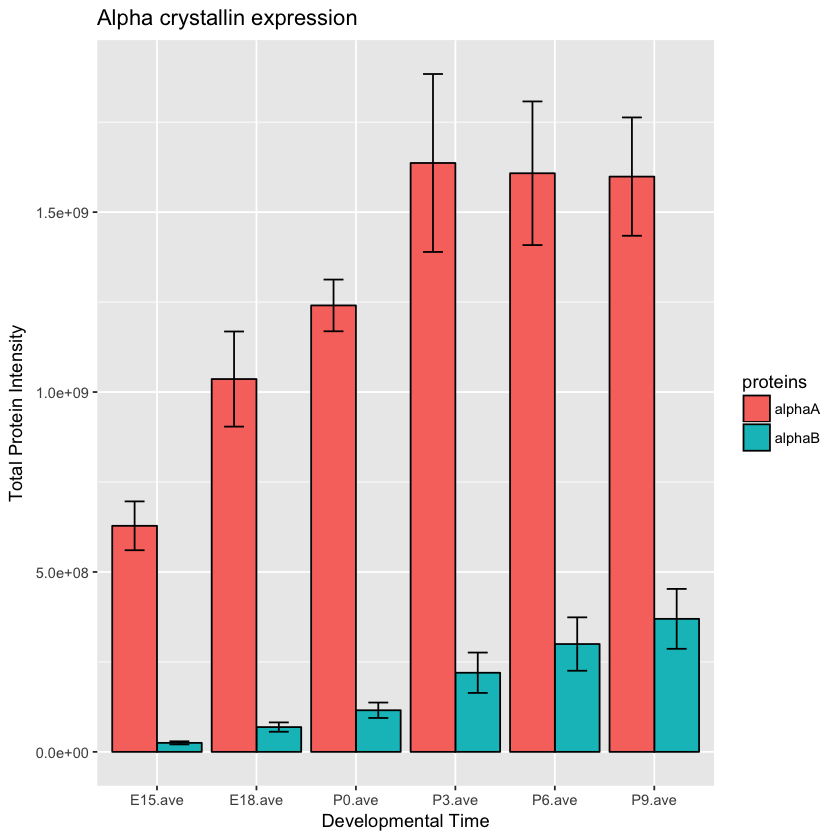

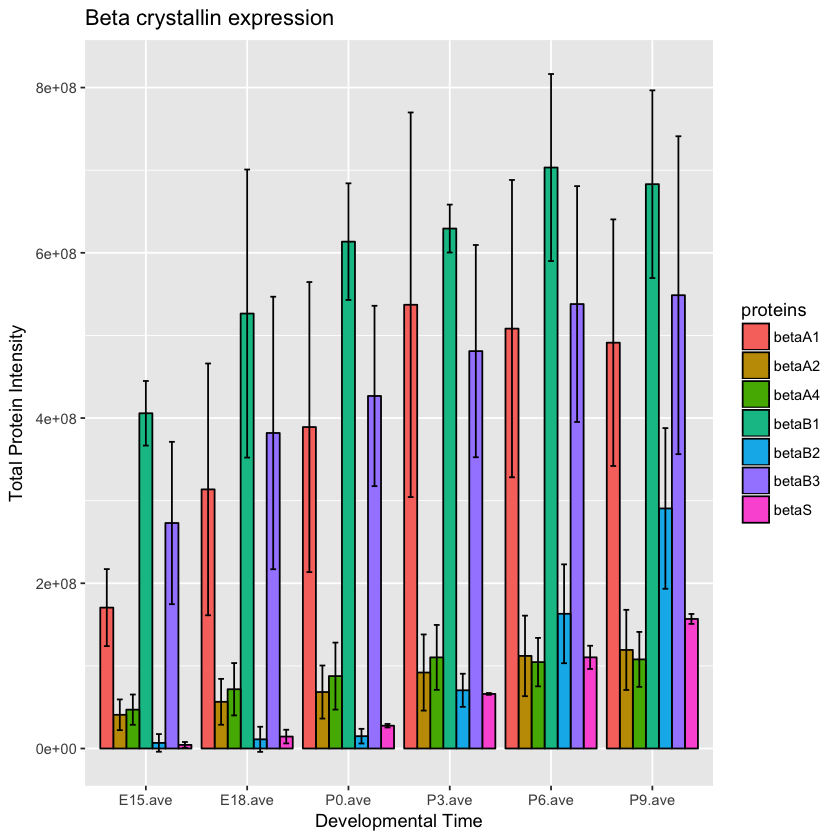

NULL

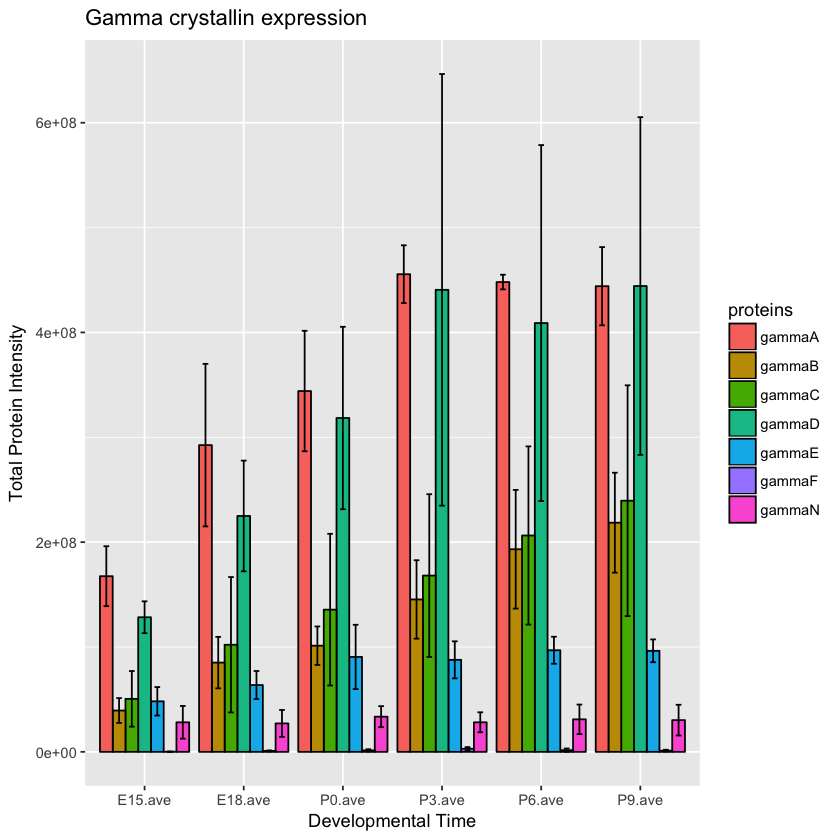

In [15]:
# get the averages and SDs for the SL data and plot the crystallins
sl_list <- make_CVs(data_sl)
plot_proteins(sl_list, annotate_df)

## Now do the IRS data

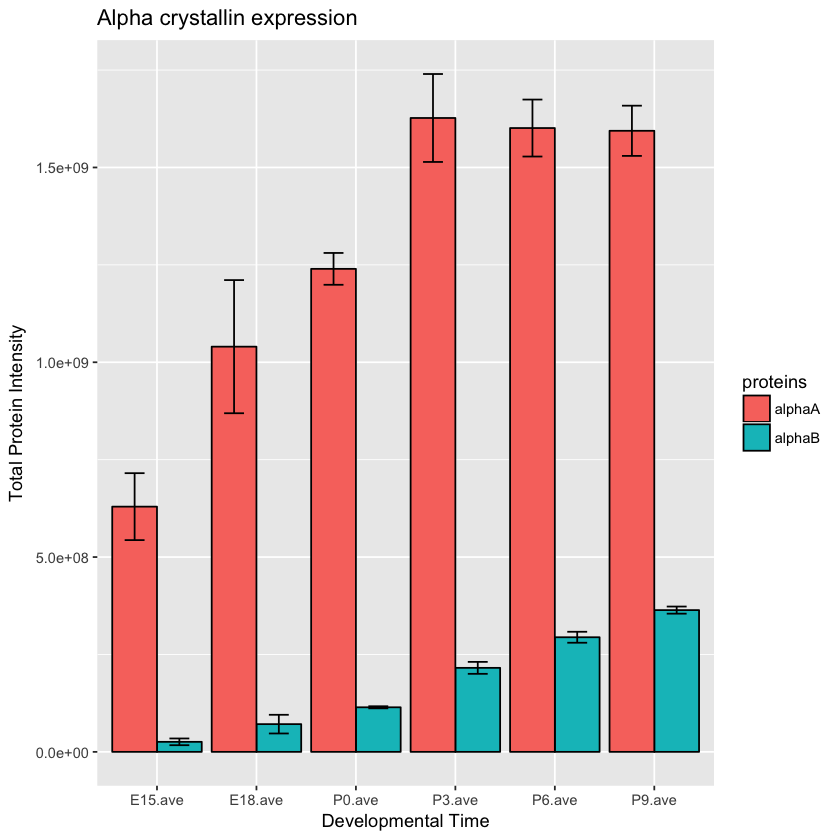

In [ ]:
# get the averages and SDs for the IRS data and plot the crystallins
irs_list <- make_CVs(data_irs)
plot_proteins(irs_list, annotate_df)

## What IRS is doing is now pretty clear
The relative bar heights, the **averages** for each crystallin, are pretty much the same with or without IRS. The uncertainties in those averages; however, are **dramatically** smaller after IRS. This is why the statistical test results are so different with and without IRS. 

In part 1 at the end, scatter plots of individual samples were compared with and without IRS. The Log2 scatter plots are one of the most informative ways to look at the data. It is the actual data that is plotted on both axes, so the plots do not get distorted by auto scaling. The inter-sample scatter plots have relative widths (the spread about the diagonal) without IRS that strongly resemble spectral counting. The inter-sample scatter plots after IRS show just how impressive isobaric tagging can be. 

Without using an IRS-like correction, combining multiple TMT experiments will degrade the quantitative performance to spectral count levels. Biological difference can be statistically significant, but only if they are large enough. This could create the confusing situation where a smaller experiment that could fit into a single TMT experiment might produce large numbers of candidates with very significant p-values. Then a scaled-up experiment that spanned multiple TMT experiments could result in few candidates with barely significant p-values. This would appear very contradictory.

## IRS is a crucial component in analyzing multiple TMT experiments
We have explored many quantitative proteomics topics in parts 1 and 2. In all shotgun quantitative proteomics studies, a good choice of protein database is very important. Simpler canonical protein databases with lower peptide redundancy should be the first choice. Repeated analyses with more complicated protein databases can be pursued for protein isoform questions. Starting with a complicated, overly complete protein database is the first place where your analysis can go wrong.

The next challenge is in how to aggregate the **insane** number of PSM data points into something more meaningful like protein expression levels. There is the general question of measurement scale. What kind of summary quantities do you want? Back in the proteomics dark ages, labeling reagents came in one light and one heavy form. There was little one could do with two number besides take a ratio. Thus, began the proteomics love affair with ratios. Ratios have so many drawbacks, it is hard to know where to begin (see Part 3 for an exploration of using ratios). Ratios just do not scale to more than two samples and, as we have seen here, there is absolutely no need to use ratios in modern quantitative proteomics. 

The elegant protein aggregation method of simply summing up all usable protein PSM values for each protein is very easy to implement and works extremely well. This greatly reduces the dimensionality of the data and gives us large magnitude numbers that work well in statistical tests designed for RNA-Seq data.

These complicated, multi-step experiments require several specific normalizations steps, each addressing particular aspects of unwanted experimental variation. We have explored a unique source of variation in isobaric labeling due to random sampling of MS2 scans that only affects reporter ions when we are combining data from multiple TMT experiments. We described the internal reference scaling (IRS) method to correct for this effect (a sort of batch effect), and demonstrated its superior performance. 

We saw that data on the correct scale is directly compatible with sophisticated statistical packages developed for genomics data. These tools, like edgeR, support typical biological study designs, and are tailored for large numbers of measurements with relatively small numbers of replicates per condition. These tools are ideally suited to these quantitative proteomics datasets.

We demonstrated just how important an IRS-like normalization step is to get correct results from these statistical tests. The advances in isobaric labeling since its inception are simply stunning. High resolution instruments allow up to 11 channels per experiment. New tribrid instruments allow for high dynamic range, clean measurements of reporter ions at excellent scan rates. And, finally, we see how a modern quantitative analysis workflow completes the transformation of isobaric labeling into a true quantitative systems biology tool.

